In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Los Angeles International Airport - Passenger Traffic By Terminal | Los Angeles - Open Data Portal 
(lacity.org)

In [29]:
df= pd.read_csv(r'..\data\raw\Los_Angeles_International_Airport_-_Passenger_Traffic_By_Terminal_20240613.csv')
df.head()

,DataExtractDate,ReportPeriod,Terminal,Arrival_Departure,Domestic_International,Passenger_Count
0,05/10/2021 06:01:09 AM,04/01/2021 12:00:00 AM,T1,Departure,Domestic,160413
1,05/03/2021 03:08:02 PM,03/01/2021 12:00:00 AM,T5,Departure,Domestic,223866
2,05/27/2021 03:16:34 PM,04/01/2021 12:00:00 AM,T5,Departure,Domestic,266035
3,07/10/2021 06:01:27 AM,06/01/2021 12:00:00 AM,T6,Arrival,International,6195
4,05/10/2021 06:01:09 AM,04/01/2021 12:00:00 AM,T8,Arrival,Domestic,54925


In [30]:
df.columns

Index(['DataExtractDate', 'ReportPeriod', 'Terminal', 'Arrival_Departure',
       'Domestic_International', 'Passenger_Count'],
      dtype='object')

In [31]:
df=df[['Terminal','ReportPeriod',  'Passenger_Count']]
df.head()

,Terminal,ReportPeriod,Passenger_Count
0,T1,04/01/2021 12:00:00 AM,160413
1,T5,03/01/2021 12:00:00 AM,223866
2,T5,04/01/2021 12:00:00 AM,266035
3,T6,06/01/2021 12:00:00 AM,6195
4,T8,04/01/2021 12:00:00 AM,54925


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7883 entries, 0 to 7882
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Terminal         7883 non-null   object
 1   ReportPeriod     7883 non-null   object
 2   Passenger_Count  7883 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 184.9+ KB


In [33]:
df['ReportPeriod']=pd.to_datetime(df['ReportPeriod'])

C:\Users\DELL\AppData\Local\Temp\ipykernel_10472\3464749832.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['ReportPeriod']=pd.to_datetime(df['ReportPeriod'])


In [34]:
df.head()

,Terminal,ReportPeriod,Passenger_Count
0,T1,2021-04-01,160413
1,T5,2021-03-01,223866
2,T5,2021-04-01,266035
3,T6,2021-06-01,6195
4,T8,2021-04-01,54925


In [35]:
# group by terminal and report period
df_grouped=df.groupby(['Terminal', 'ReportPeriod']).sum().reset_index()
df_grouped.head()

,Terminal,ReportPeriod,Passenger_Count
0,Imperial Terminal,2006-01-01,988
1,Imperial Terminal,2006-02-01,366
2,Imperial Terminal,2006-03-01,410
3,Imperial Terminal,2006-04-01,990
4,Imperial Terminal,2006-05-01,538


In [36]:
df_grouped['Terminal'].value_counts()

Terminal
T1                        214
T2                        214
T4                        214
T5                        214
T6                        214
T7                        214
TBIT                      214
T8                        213
Miscellaneous Terminal    212
T3                        192
Imperial Terminal          49
TBIT West Gates            30
Name: count, dtype: int64

In [37]:
df_grouped=df_grouped[(df_grouped['Terminal']!='TBIT West Gates') & (df_grouped['Terminal']!='Imperial Terminal')]

In [38]:
# df_grouped=df_grouped.set_index('ReportPeriod')
# df_grouped = df_grouped.resample('M').sum()
# df_grouped.head()

In [39]:
# pivot table with terminal as columns and report period as index. fill missing values with 0. then, unstack the table
df_pivot=df_grouped.pivot_table(index='ReportPeriod', columns='Terminal', values='Passenger_Count', fill_value=0).unstack().reset_index()
df_pivot.head()

,Terminal,ReportPeriod,0
0,Miscellaneous Terminal,2006-01-01,1441.0
1,Miscellaneous Terminal,2006-02-01,397.0
2,Miscellaneous Terminal,2006-03-01,1328.0
3,Miscellaneous Terminal,2006-04-01,938.0
4,Miscellaneous Terminal,2006-05-01,540.0


In [40]:
# rename columns
df_pivot.columns=['Terminal', 'ReportPeriod', 'Passenger_Count']
df_pivot.head()

,Terminal,ReportPeriod,Passenger_Count
0,Miscellaneous Terminal,2006-01-01,1441.0
1,Miscellaneous Terminal,2006-02-01,397.0
2,Miscellaneous Terminal,2006-03-01,1328.0
3,Miscellaneous Terminal,2006-04-01,938.0
4,Miscellaneous Terminal,2006-05-01,540.0


In [41]:
df_pivot['Terminal'].value_counts()

Terminal
Miscellaneous Terminal    214
T1                        214
T2                        214
T3                        214
T4                        214
T5                        214
T6                        214
T7                        214
T8                        214
TBIT                      214
Name: count, dtype: int64

<Axes: xlabel='Terminal', ylabel='Passenger_Count'>

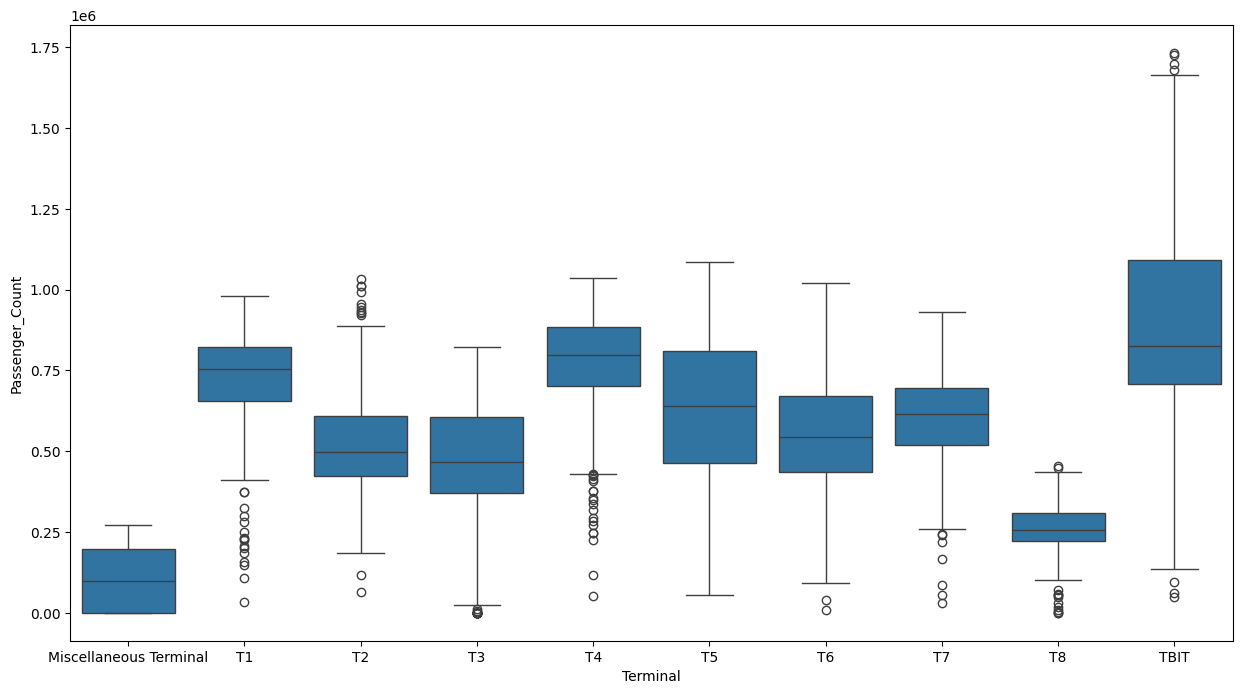

In [42]:
# draw boxplot for each terminal
plt.figure(figsize=(15, 8))
sns.boxplot(data=df_pivot, x='Terminal', y='Passenger_Count')

<Axes: xlabel='Terminal', ylabel='Passenger_Count'>

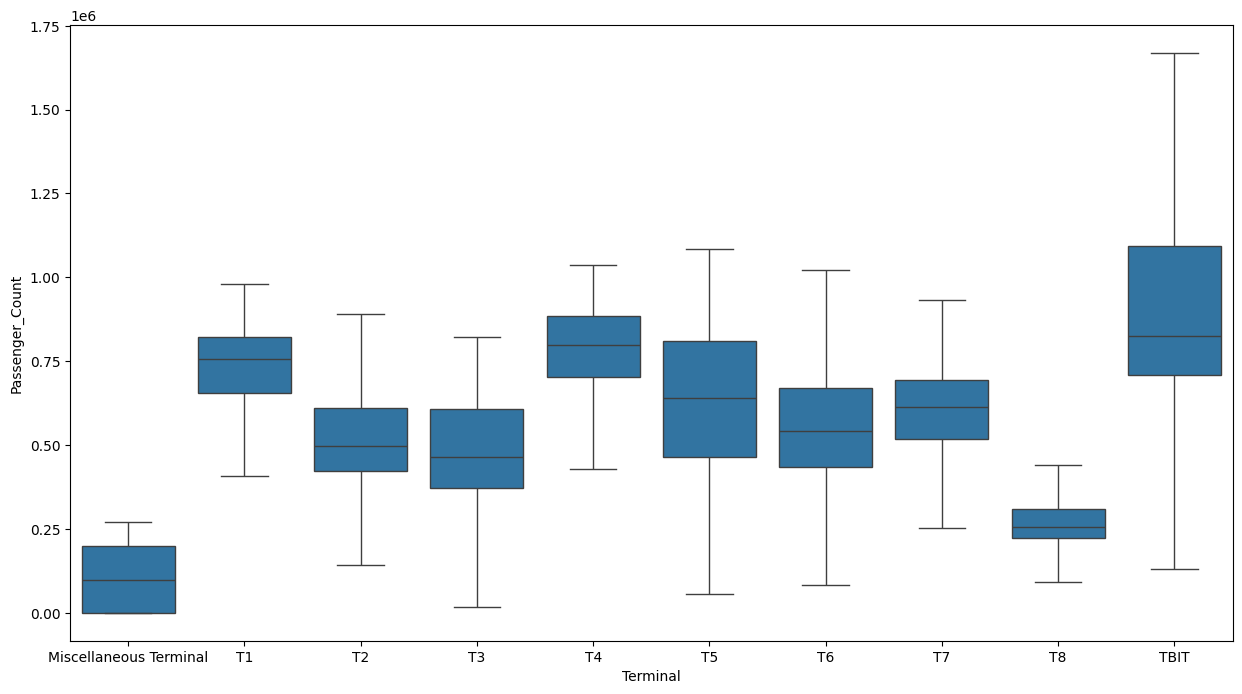

In [43]:
# handle outliers for each terminal separately using loop
for terminal in df_pivot['Terminal'].unique():
    q1 = df_pivot[df_pivot['Terminal']==terminal]['Passenger_Count'].quantile(0.25)
    q3 = df_pivot[df_pivot['Terminal']==terminal]['Passenger_Count'].quantile(0.75)
    iqr = q3-q1
    lower_bound = q1-1.5*iqr
    upper_bound = q3+1.5*iqr
    df_pivot.loc[(df_pivot['Terminal']==terminal) & (df_pivot['Passenger_Count']<lower_bound), 'Passenger_Count'] = lower_bound
    df_pivot.loc[(df_pivot['Terminal']==terminal) & (df_pivot['Passenger_Count']>upper_bound), 'Passenger_Count'] = upper_bound

# draw boxplot for each terminal after handling outliers
plt.figure(figsize=(15, 8))
sns.boxplot(data=df_pivot, x='Terminal', y='Passenger_Count')

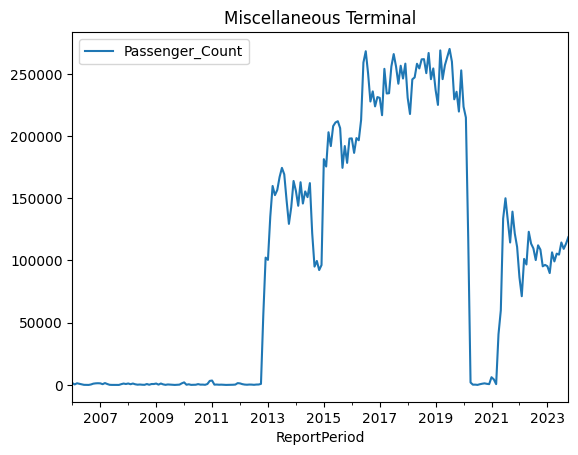

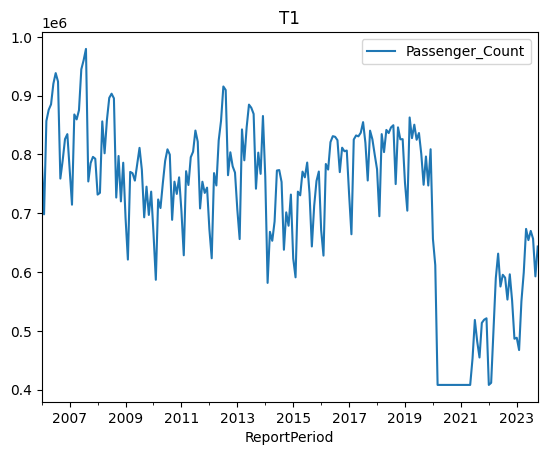

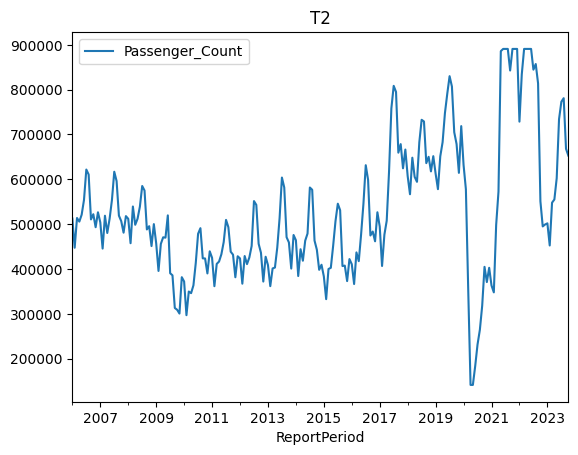

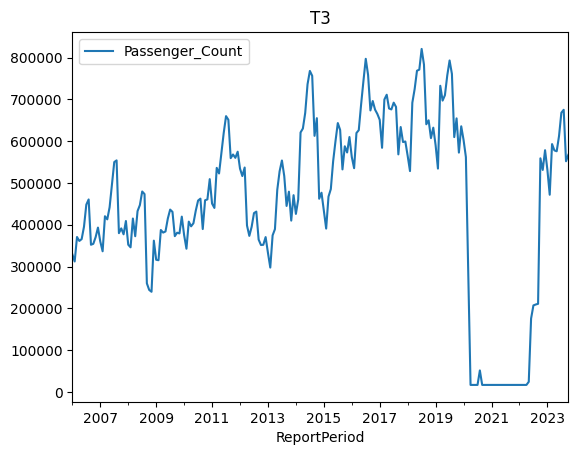

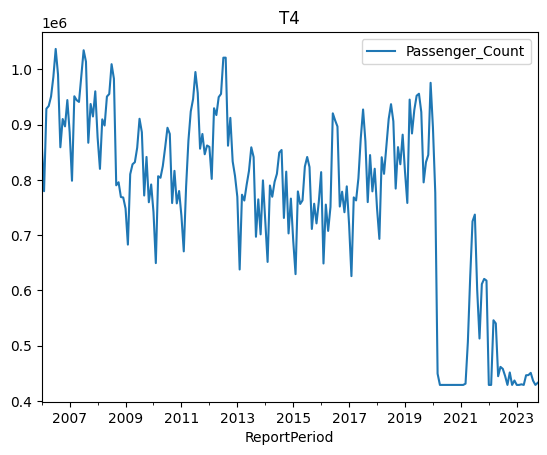

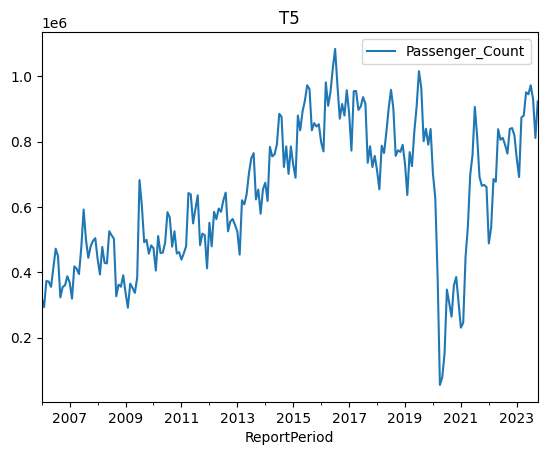

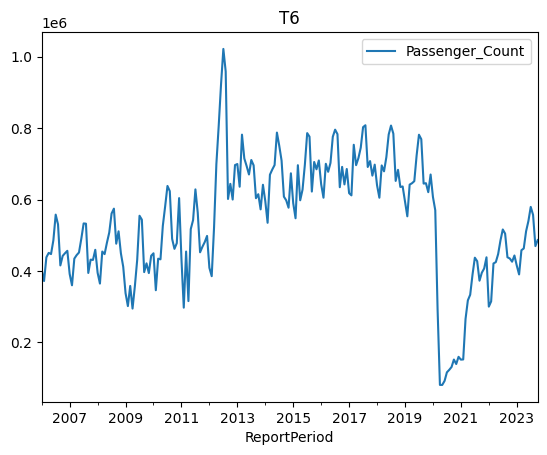

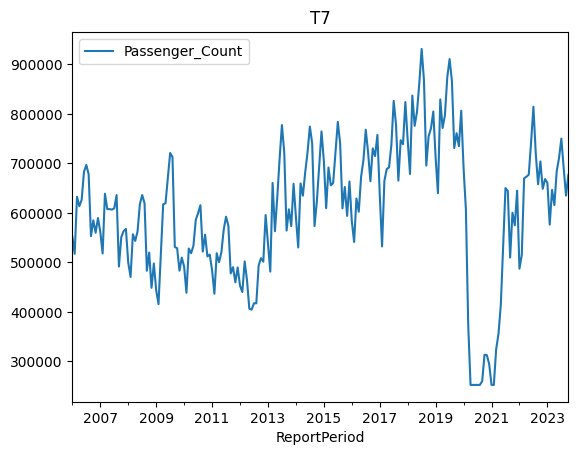

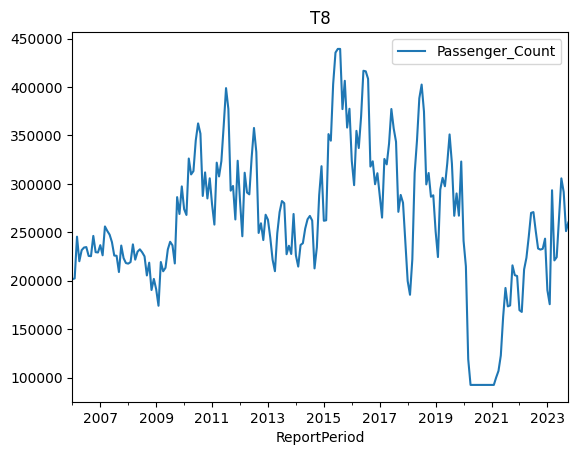

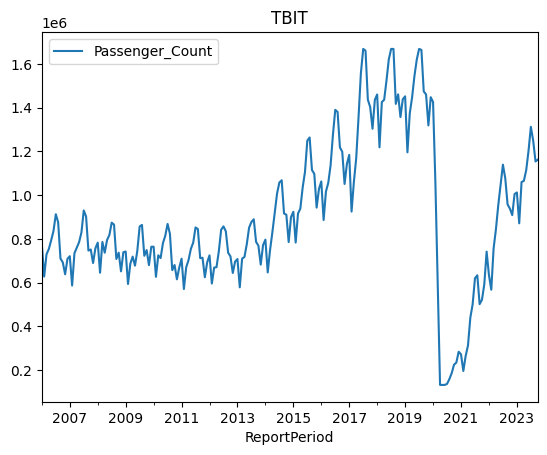

In [44]:
# plot passenger count by terminal in separate plots
for terminal in df_pivot['Terminal'].unique():
    df_pivot[df_pivot['Terminal']==terminal].plot(x='ReportPeriod', y='Passenger_Count', title=terminal)
    plt.show()

Miscellaneous Terminal


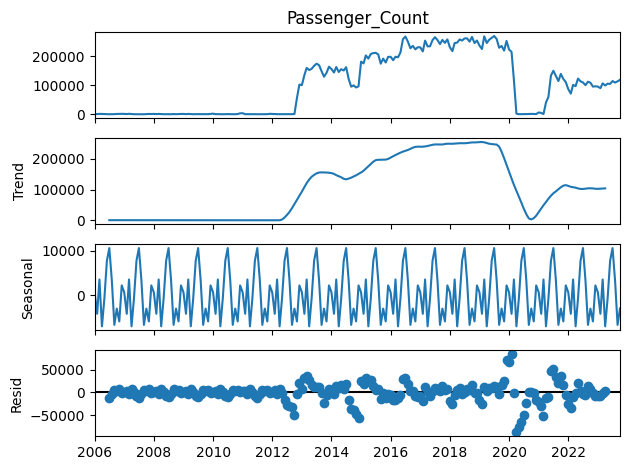

T1


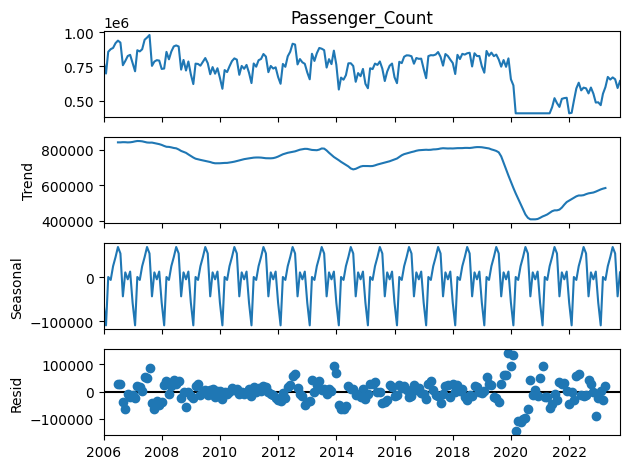

T2


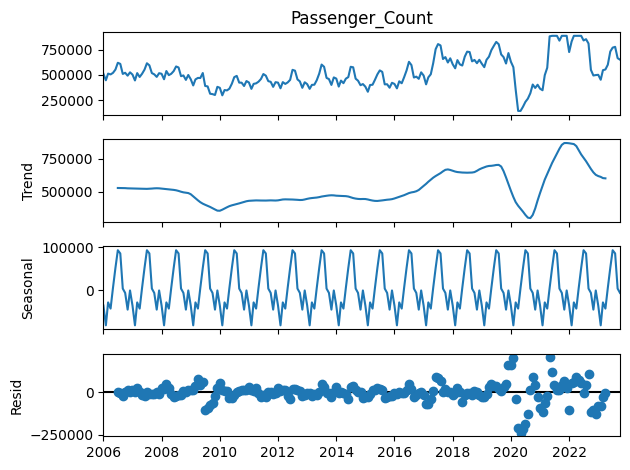

T3


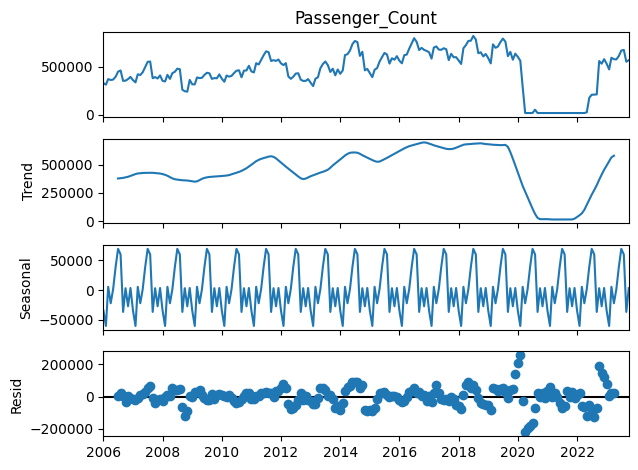

T4


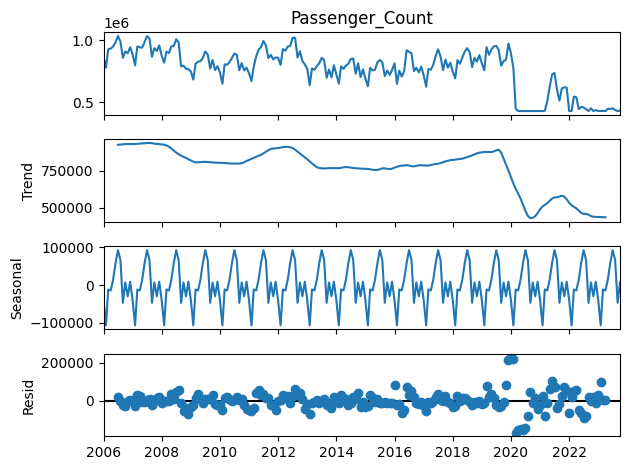

T5


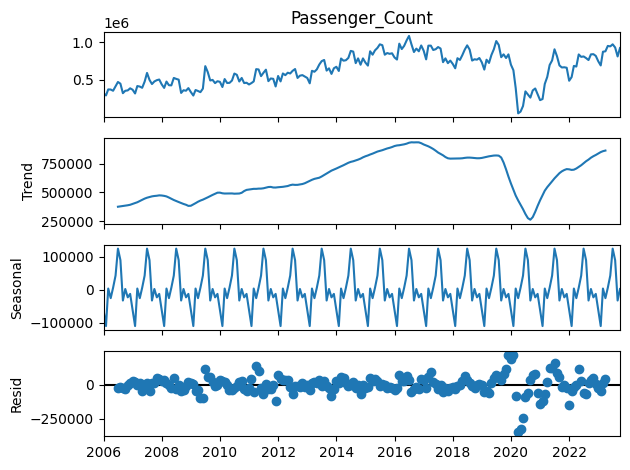

T6


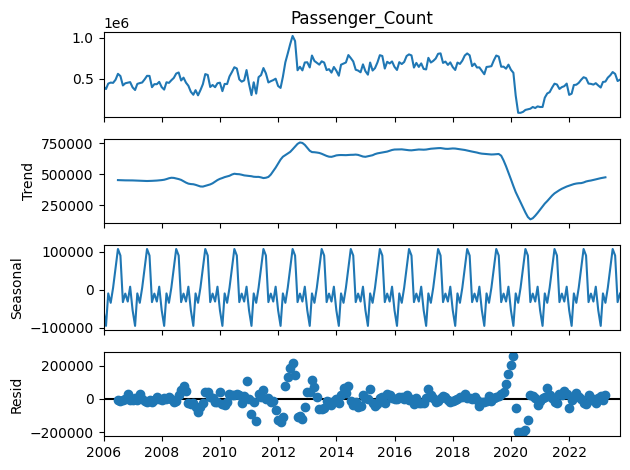

T7


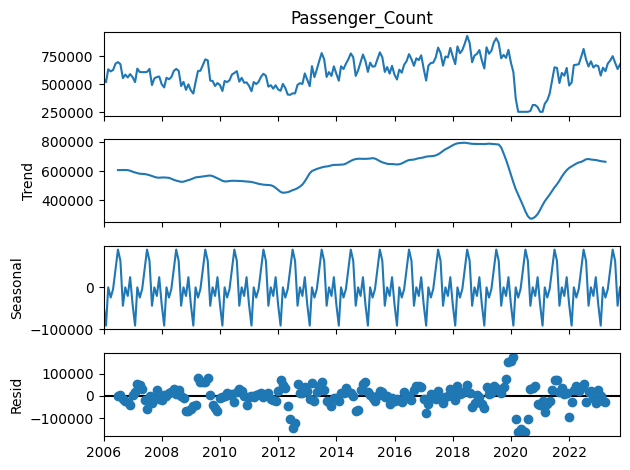

T8


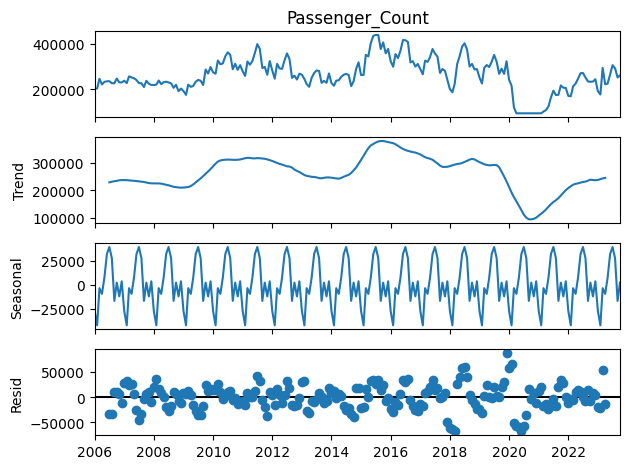

TBIT


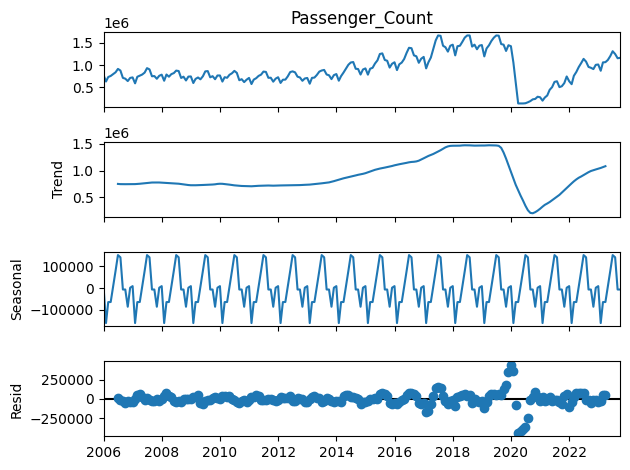

In [45]:
# plot time series decomposition for each terminal
from statsmodels.tsa.seasonal import seasonal_decompose
for terminal in df_pivot['Terminal'].unique():
    print(terminal)
    df_terminal=df_pivot[df_pivot['Terminal']==terminal]
    df_terminal=df_terminal.set_index('ReportPeriod')
    result = seasonal_decompose(df_terminal['Passenger_Count'], model='additive')
    result.plot()
    plt.show()

In [51]:
# df_pivot.to_csv(r'..\data\processed\Passenger_Traffic_Los_Angeles.csv', index=False)

In [47]:
df.describe()

,ReportPeriod,Passenger_Count
count,7883,7883.000000
mean,2014-11-19 00:43:28.550044416,150115.125079
min,2006-01-01 00:00:00,0.000000
25%,2010-06-01 00:00:00,19849.500000
50%,2014-12-01 00:00:00,97231.000000
75%,2019-04-01 00:00:00,259746.500000
max,2023-10-01 00:00:00,908951.000000
std,NaN,152305.478195
